<h1>Chord Representation and Indexing with Chromagrams</h1>
<br>
In this Notebook we are going to explore a different approach on the preprocessing of chord annotations and spectrogramms.<br>
We used one hot encodings for every timestep of the spectrogram, and saw the enormous amount of memory that was needed.<br>
<br>

In [1]:
import sys
# do this only once
sys.path.append('./src/audio-processing/')
sys.path.append('./src/data-processing/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#librosa
import librosa
import librosa.display

#import custom modules
import filters
import spectrograms
import audiofiles
from annotation_processing import chords_to_onehot

<h2>Chord Representations</h2><br>
<b>Idea: </b> Instead of having one hot vectors of size N, where N is the number of unique chords in the dataset, we will connect the notes with the chords. Meaning, a <b>G</b> chord is comprised of a G, B and a D. <b>G7</b> is comprised of G,B,D,F. <b>C#</b> is comprised of C#,E#(F),G#. Etc.<br>
<br><b>Explore the use of Chromagrams instead of spectrograms</b><br>
https://musicinformationretrieval.com/chroma.html<br>
<br>
So, let's build a tool, that will <u>map</u> <b>Chords to Notes</b> and <b>Notes to Chords</b><br>

In [3]:
Semitones = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [4]:
def Chord_to_Notes(chord):
    if chord == 'N':
        return []
    if chord in Semitones:
        c = pc.Chord(chord)
        return c.components()
    #to get here means, this chord is augmented/diminished or inversed
    #I need to build smthing here for them
    return Semitones

In [5]:
def Notes_to_Chord(Notes):
    Chords = []
    for Note_Set in Notes:
        Chords.append(pc.note_to_chord(Note_Set))
    return Chords

In [6]:
def Extend_Annotations(filename):
    chordlab = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)
    #init list
    notes = []
    for counter in range(len(Semitones)):
        notes.append([])
    #loop over annotation chords
    for Annotation in chordlab['Chord']:
        Notes_exist = Chord_to_Notes(Annotation)
        counter = 0
        for note in Semitones:
            if note not in Notes_exist:
                notes[counter].append(0)
            else:
                notes[counter].append(1)
            counter += 1 
    #append note lists on pandas dataframe
    counter = 0
    for note in Semitones:
        chordlab[note] = notes[counter]
        counter += 1
        
    return chordlab

After we built these tools, we will create a dataset, where the encodings of each chord won't be of size (407,1) but of (#NumberOfNotes,1)

In [7]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = Extend_Annotations(filename)

In [8]:
#Display chordlab format
display (Chordlab['The Beatles'][album][track_no])

,Starts,Ends,Chord,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0.000000,0.511897,N,0,0,0,0,0,0,0,0,0,0,0,0
1,0.511897,3.376166,D,0,0,1,0,0,0,1,0,0,1,0,0
2,3.376166,6.178742,E:min,1,1,1,1,1,1,1,1,1,1,1,1
3,6.178742,7.585845,B:min,1,1,1,1,1,1,1,1,1,1,1,1
4,7.585845,9.027834,A,0,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,138.388235,139.562757,E:min,1,1,1,1,1,1,1,1,1,1,1,1
82,139.562757,141.109407,A,0,1,0,0,1,0,0,0,0,1,0,0
83,141.109407,142.342076,E:min,1,1,1,1,1,1,1,1,1,1,1,1
84,142.342076,144.391973,A,0,1,0,0,1,0,0,0,0,1,0,0


<h2>Chromagrams</h2>
<br>
1. Constructing chromagram from raw audio:<br>

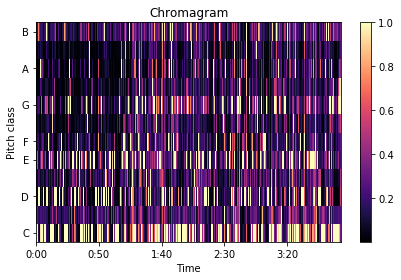

In [13]:
track, sr = librosa.load('Audiofiles/The Beatles/12_-_Let_It_Be/wav/06.Let It Be (Remastered 2009).wav')
track_time = librosa.get_duration(y=track, sr=sr)

hop_length = 512
n_fft = int(track_time // (hop_length / sr))

chroma = librosa.feature.chroma_stft(track, sr=sr, n_fft=n_fft, hop_length=hop_length)

librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [14]:
chroma.shape

(12, 10469)

<h2>Estimation using Chromagrams (Underfitting due to the number of features)</h2>

<h3>Loading Datasets</h3>

In [9]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

<h3>Chord Vocab</h3>

In [10]:
### Load all chords in a dictionary
Chords = []
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: Chords.append(row['Chord'])
                
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  407


<h3>Create Chromagrams</h3>

In [11]:
hop_length = 512
Semitones = 12

### get all audio files and create chromagram for each track
Chromagrams, Timestamps = spectrograms.create_chromagrams(hop_length, 'Audiofiles/The Beatles')

<h3>Preprocessings</h3>

<h4>One hot encodings with sklearn</h4>

In [12]:
encoder = OneHotEncoder()
encoder.fit(np.array(pd.Series(Chords)).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

<h4>Indexing chroma with timesteps</h4>

In [13]:
chords2vec = chords_to_onehot(encoder, Timestamps, Chordlab, Chords)

<h4>Constructing numpy arrays</h4>

In [14]:
x_initial_train = np.zeros((1,Semitones))
y_initial_train = np.zeros((1,len(Chords)))
x_initial_test = np.zeros((1,Semitones))
y_initial_test = np.zeros((1,len(Chords)))

test_track_no = '06'
for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        if track_no != '06' or album != '12_-_Let_It_Be':
            y_initial_train = np.append(y_initial_train, chords2vec[album][track_no].T, axis = 0)
            x_initial_train = np.append(x_initial_train, Chromagrams['The Beatles'][album][track_no], axis = 0)
        else:
            y_initial_test = np.append(y_initial_test, chords2vec[album][track_no].T, axis = 0)
            x_initial_test = np.append(x_initial_test, Chromagrams['The Beatles'][album][track_no], axis = 0)

print (x_initial_train.shape, y_initial_train.shape)

(1248060, 12) (1248060, 407)


<h4>Normalization</h4>

In [15]:
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(x_initial_train)
# transform training dataset
x_initial_train = scaler.transform(x_initial_train)

# fit scaler on training dataset
scaler.fit(x_initial_test)
# transform training dataset
x_initial_test = scaler.transform(x_initial_test)

<h4>Slicing</h4>

In [16]:
# Find the chunk size
chunk_size = 500

In [17]:
# Slicing
x_train = np.zeros((1,chunk_size,Semitones)) #num of frequencies
y_train = np.zeros((1,chunk_size,len(Chords)))

timestep = 0
chunks = x_initial_train.shape[0]
while timestep < chunks :
    if (chunks - timestep) > chunk_size:
        batch_x = np.resize(x_initial_train[timestep:timestep+chunk_size,:], (1, chunk_size, Semitones)) #num of frequencies
        x_train = np.append(x_train, batch_x, axis = 0)
        batch_y = np.resize(y_initial_train[timestep:timestep+chunk_size,:], (1, chunk_size,len(Chords)))
        y_train = np.append(y_train, batch_y, axis = 0)
    else:
        batch_x = x_initial_train[timestep:,:]
        batch_y = y_initial_train[timestep:,:]
        for step in range (0, chunk_size + timestep - chunks):
            batch_x = np.vstack((batch_x, np.zeros((1,Semitones))))
            batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
        x_train = np.append(x_train, np.array([batch_x]), axis = 0)
        y_train = np.append(y_train, np.array([batch_y]), axis = 0)
    timestep += chunk_size
    
print (x_train.shape)
print (y_train.shape)

#delete first line batch of array because its zeros

(2498, 500, 12)
(2498, 500, 407)


In [18]:
# Slicing
x_test = np.zeros((1,chunk_size,Semitones)) #num of frequencies
y_test = np.zeros((1,chunk_size,len(Chords)))

timestep = 0
chunks = x_initial_test.shape[0]
while timestep < chunks :
    if (chunks - timestep) > chunk_size:
        batch_x = np.resize(x_initial_test[timestep:timestep+chunk_size,:], (1, chunk_size, Semitones)) #num of frequencies
        x_test = np.append(x_test, batch_x, axis = 0)
        batch_y = np.resize(y_initial_test[timestep:timestep+chunk_size,:], (1, chunk_size,len(Chords)))
        y_test = np.append(y_test, batch_y, axis = 0)
    else:
        batch_x = x_initial_test[timestep:,:]
        batch_y = y_initial_test[timestep:,:]
        for step in range (0, chunk_size + timestep - chunks):
            batch_x = np.vstack((batch_x, np.zeros((1,Semitones))))
            batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
        x_test = np.append(x_test, np.array([batch_x]), axis = 0)
        y_test = np.append(y_test, np.array([batch_y]), axis = 0)
    timestep += chunk_size
    
print (x_test.shape)
print (y_test.shape)

#delete first line batch of array because its zeros

(22, 500, 12)
(22, 500, 407)


Delete the first row from every array because of the append, which left it all zeros.

In [19]:
x_train = np.delete(x_train,0,0)
y_train = np.delete(y_train,0,0)
x_test = np.delete(x_test,0,0)
y_test = np.delete(y_test,0,0)

In [20]:
print(x_train.shape)
print(y_train.shape)
print (x_test.shape)
print (y_test.shape)

(2497, 500, 12)
(2497, 500, 407)
(21, 500, 12)
(21, 500, 407)


In [173]:
x_train2 = np.reshape(x_train,(2497, 500, 12, 1))
y_train2 = np.reshape(y_train,(2497, 500, 407, 1))
x_test2 = np.reshape(x_test,(21, 500, 12, 1))
y_test2 = np.reshape(y_test,(21, 500, 407, 1))

## Neural Network

In [143]:
from tensorflow.keras.layers import Input, TimeDistributed, Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, LocallyConnected1D, Activation, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

In [170]:
def BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 40, 
                           kernel_initializer = 'glorot_uniform',
                           recurrent_activation='sigmoid',
                           return_sequences = True))(main_input)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 40,
                           kernel_initializer = 'glorot_uniform',
                           recurrent_activation='sigmoid',
                           return_sequences=True))(x)
    
    x = TimeDistributed(Activation('sigmoid'))(x)
    #Dense for classification
    main_output = TimeDistributed(Dense(chords_num, activation='softmax'))(x)
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

In [213]:
def Conv1D_BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num,1), name='main_input')
    
    #Convolutional Layer
    c =  TimeDistributed(Conv1D(filters=32, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, frequencies_num, 1))(main_input)
    
    c = Dropout(0.2)(c)
    
    #Convolutional Layer
    c =  TimeDistributed(Conv1D(filters=32, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, frequencies_num, 1))(c)
    
    c = Dropout(0.2)(c)
    
    #Convolutional Layer
    c =  TimeDistributed(Conv1D(filters=64, 
               kernel_size=5, 
               padding='same'), input_shape=(timesteps, frequencies_num, 1))(c)
    
    c = Dropout(0.2)(c)
    
    #Convolutional Layer
    c =  TimeDistributed(Conv1D(filters=64, 
               kernel_size=5, 
               padding='same'), input_shape=(timesteps, frequencies_num, 1))(c)
    
    c = Dropout(0.2)(c)
    
    x = TimeDistributed(Flatten())(c)
    x = BatchNormalization()(x)
    
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 20,
                           kernel_initializer = 'glorot_uniform',
                           recurrent_activation='sigmoid',
                           return_sequences=True))(x)
    
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 20,
                           kernel_initializer = 'glorot_uniform',
                           recurrent_activation='sigmoid',
                           return_sequences=True))(x)
    
    #Dense for classification
    main_output = TimeDistributed(Dense(chords_num, activation='softmax'))(x)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

In [214]:
epochs = 50
batch_size = 32

chroma_model = Conv1D_BLSTM_2Layer(len(Chords), Semitones, chunk_size, batch_size)

chroma_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


# train
callback_history = chroma_model.fit(x_train2, y_train, epochs=epochs,
          validation_data=(x_test2, y_test), batch_size=batch_size, verbose=1)

chroma_model.summary()

Train on 2497 samples, validate on 21 samples
Epoch 1/50
2497/2497 [==============================] - 47s 19ms/sample - loss: 4.6721 - accuracy: 0.2660 - val_loss: 3.3877 - val_accuracy: 0.2381
Epoch 2/50
2497/2497 [==============================] - 44s 18ms/sample - loss: 3.2981 - accuracy: 0.3304 - val_loss: 3.3037 - val_accuracy: 0.2653
Epoch 3/50
2497/2497 [==============================] - 44s 18ms/sample - loss: 3.0191 - accuracy: 0.3762 - val_loss: 3.0153 - val_accuracy: 0.3293
Epoch 4/50
2497/2497 [==============================] - 44s 18ms/sample - loss: 2.8471 - accuracy: 0.4005 - val_loss: 2.9192 - val_accuracy: 0.3793
Epoch 5/50
2497/2497 [==============================] - 44s 18ms/sample - loss: 2.7159 - accuracy: 0.4200 - val_loss: 2.8270 - val_accuracy: 0.3792
Epoch 6/50
2497/2497 [==============================] - 44s 18ms/sample - loss: 2.6395 - accuracy: 0.4287 - val_loss: 3.1510 - val_accuracy: 0.2972
Epoch 7/50
2497/2497 [==============================] - 44s 18ms/s

In [216]:
# evaluate on test set
scores = chroma_model.evaluate(x_test2, y_test, verbose=0)
print("Final test loss and accuracy :", scores)

Final test loss and accuracy : [2.373098134994507, 0.48371428]


In [217]:
predictions = chroma_model.predict(x_test2, batch_size=batch_size, use_multiprocessing=True)

In [218]:
estimated_chord_list = []
real_chord_list = Chordlab['The Beatles']['12_-_Let_It_Be'][test_track_no]

for batch_chords in predictions:
    for chord in batch_chords:
        estimated_chord_list.append(encoder.inverse_transform([chord]).reshape(1,)[0])
        
df_predictions = pd.DataFrame({'Estimated Chords' : estimated_chord_list})
display(df_predictions)

,Estimated Chords
0,C
1,C
2,C
3,C
4,C
...,...
10495,N
10496,N
10497,N
10498,N


### Plot Efficiency of model

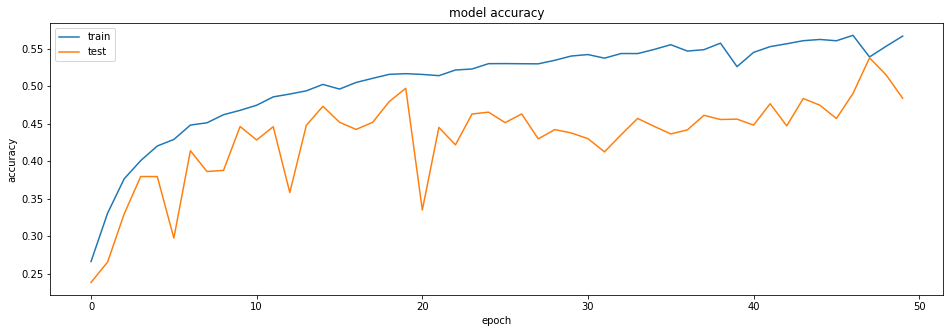

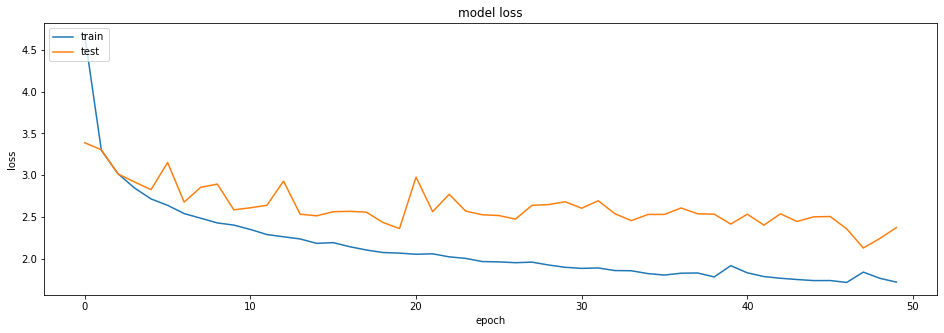

In [219]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(callback_history.history['accuracy'])
plt.plot(callback_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(callback_history.history['loss'])
plt.plot(callback_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()